In [ ]:
"""
see how well the density and reconstruction loss are related for different token counts
"""

In [1]:
import json
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
from data.utils.dataloaders import ReconstructionDataset_Heuristic

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read the density json file
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/densities_new_imagenet/train/all_density_values.json', 'r') as f:
    density_data = json.load(f)

In [3]:
# read reconstruction loss json file 
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses_new/all_reconstruction_losses.json', 'r') as f:
    reconst_losses = json.load(f)

In [4]:
# this dataset holds the image_id, k_value, reconstruction_losses and optionally LID, density, edge ratio
dataset = ReconstructionDataset_Heuristic(
    reconstruction_data=reconst_losses,
    local_density_information=density_data,
    error_key=['LPIPS', 'L1Loss']
)

In [5]:
print(dataset[0])

{'LPIPS': 0.6564347743988037, 'L1Loss': 0.30568787455558777, 'k_value': 1, 'image_id': 0, 'local_density': 38177.3984375}


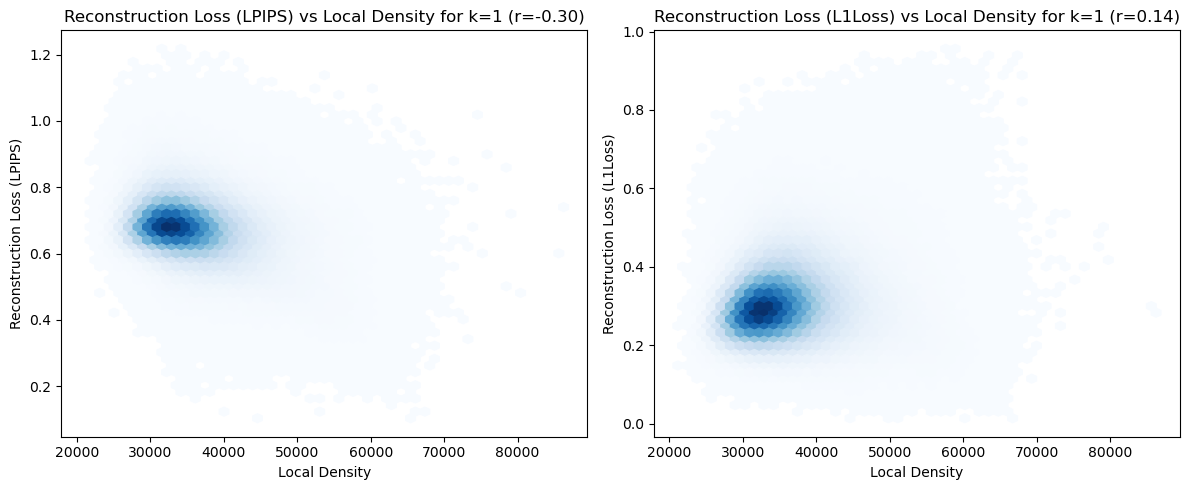

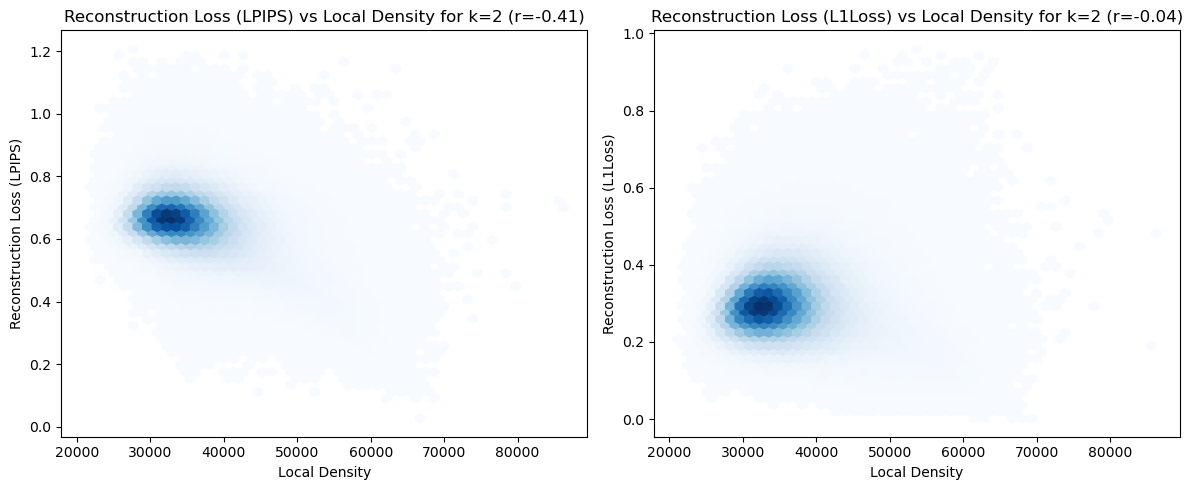

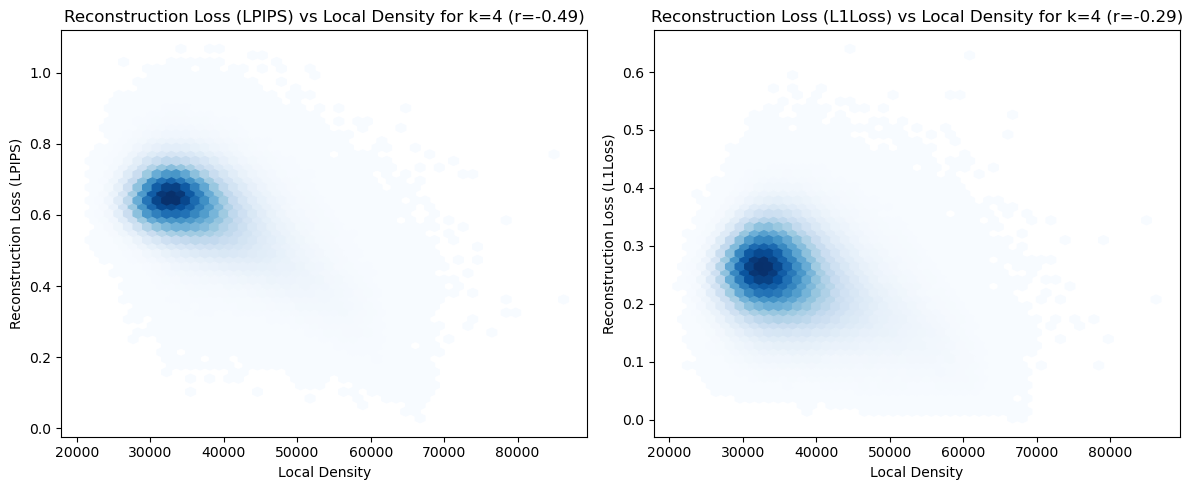

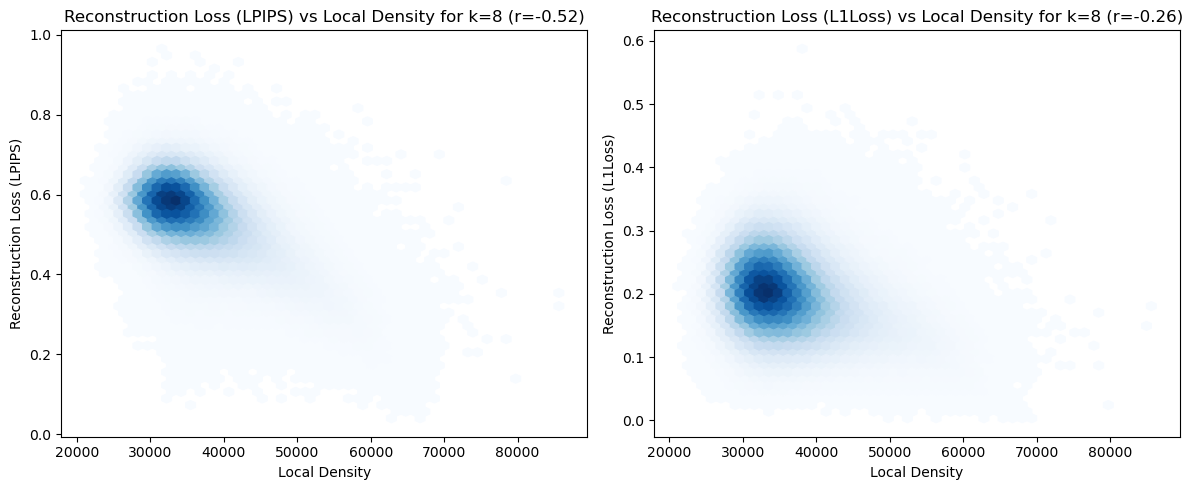

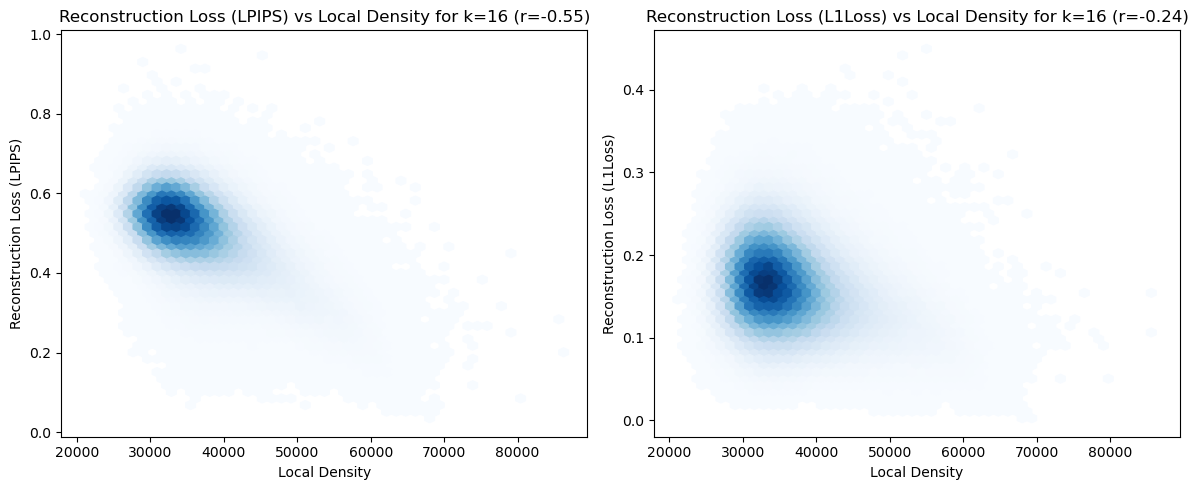

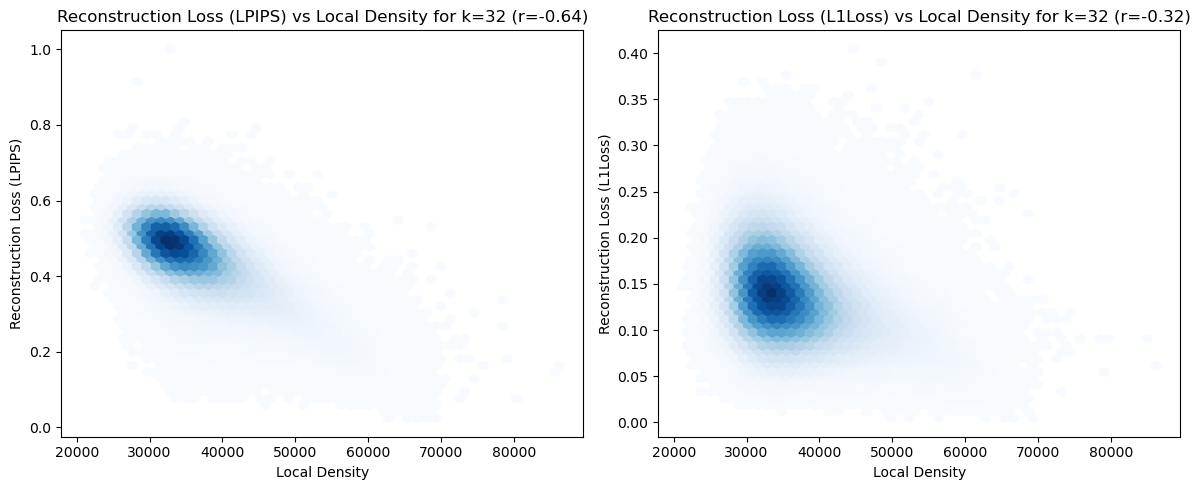

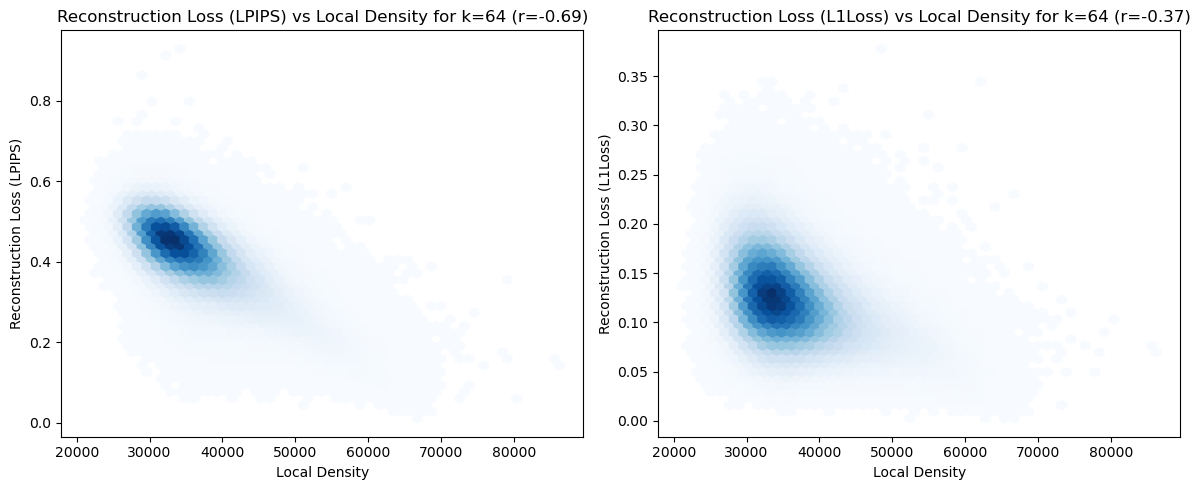

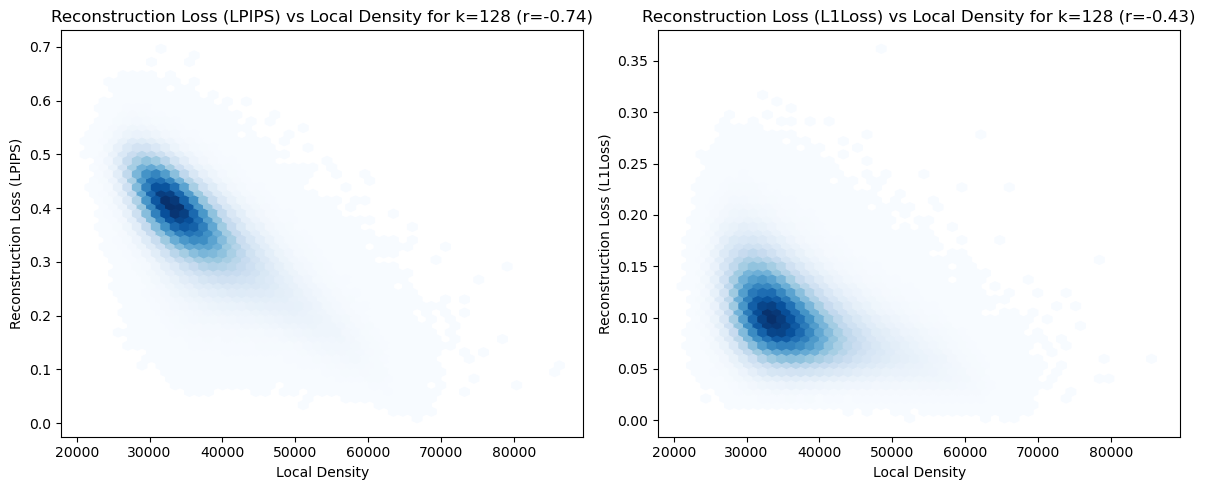

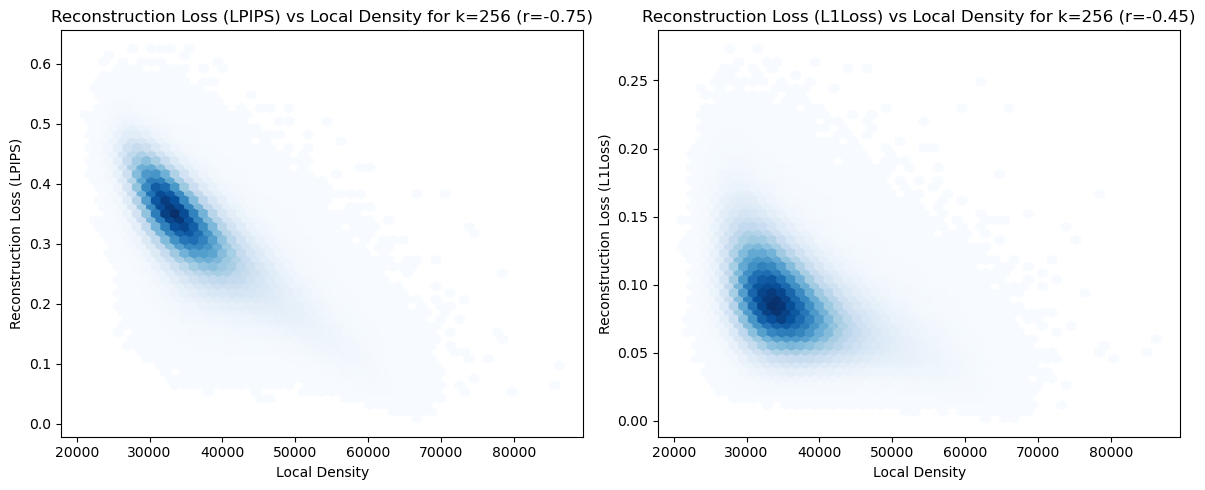

In [7]:
# show teh relation between density and reconstruction loss for different k_values

k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]
for k in k_values:
    densities = []
    losses_lpips = []
    losses_l1 = []
    for data_point in dataset:
        if data_point['k_value'] == k:
            densities.append(data_point['local_density'])
            losses_lpips.append(data_point['LPIPS'])
            losses_l1.append(data_point['L1Loss'])
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hexbin(densities, losses_lpips, gridsize=50, cmap='Blues', mincnt=1)
    # also find the pearson correlation coefficient
    if len(densities) > 1:
        corr = np.corrcoef(densities, losses_lpips)[0, 1]
        plt.title(f'Reconstruction Loss (LPIPS) vs Local Density for k={k} (r={corr:.2f})')
    plt.xlabel('Local Density')
    plt.ylabel('Reconstruction Loss (LPIPS)')

    plt.subplot(1,2,2)
    plt.hexbin(densities, losses_l1, gridsize=50, cmap='Blues', mincnt=1)
    plt.xlabel('Local Density')
    plt.ylabel('Reconstruction Loss (L1Loss)')
    if len(densities) > 1:
        corr = np.corrcoef(densities, losses_l1)[0, 1]
        plt.title(f'Reconstruction Loss (L1Loss) vs Local Density for k={k} (r={corr:.2f})')
    plt.tight_layout()
    plt.show()

In [ ]:
class ReconstructionDataset_Heuristic(Dataset):
    """
    this is different from ReconstructionDataset_token_based in the sense that this also has the edge information.
    Optionally, it can include additional per-image scalar features such as LID and local density.
    """
    def __init__(self, reconstruction_data, edge_ratio_information=None,
                 lid_information=None, local_density_information=None,
                 filter_key: str | None = None,
                 min_error: float | None = None,
                 max_error: float | None = None,
                 error_key: list[str] = ["vgg_error"]):
        """
        Args:
            reconstruction_data (list): List of dicts containing reconstruction metrics.
                (img_id, k_value, mse_error, vgg_error, ...).
            edge_ratio_information (list|dict|None): Per-image edge ratio values.
            lid_information (list|dict|None): Per-image LID values.
            local_density_information (list|dict|None): Per-image local density values.
            filter_key (str|None): Optional key in reconstruction_data to filter by value range.
            min_error, max_error (float|None): Inclusive bounds for filtering.
            error_key (str): Name of the error field in reconstruction_data to expose in samples.
        """
        self.reconstruction_data = reconstruction_data
        self.edge_ratio_information = edge_ratio_information
        self.lid_information = lid_information
        self.local_density_information = local_density_information

        # Apply optional filtering on the provided error field
        self.num_original = len(reconstruction_data)
        if filter_key is not None and (min_error is not None or max_error is not None):
            lo = float(min_error) if min_error is not None else float("-inf")
            hi = float(max_error) if max_error is not None else float("inf")
            filtered = []
            missing_key = 0
            for d in reconstruction_data:
                if filter_key not in d:
                    missing_key += 1
                    continue
                v = d[filter_key]
                try:
                    val = float(v)
                except (TypeError, ValueError):
                    continue
                if lo <= val <= hi:
                    filtered.append(d)
            self.reconstruction_data = filtered
            self.filter_key = filter_key
            self.filter_bounds = (lo, hi)
            self.missing_key_count = missing_key
        else:
            self.reconstruction_data = reconstruction_data
            self.filter_key = None
            self.filter_bounds = None
            self.missing_key_count = 0

        self.num_kept = len(self.reconstruction_data)
        self.error_key = error_key

    def __len__(self):
        return len(self.reconstruction_data)

    def __getitem__(self, idx):
        """
        Returns a dict with:
          - error value under `self.error_key`
          - k_value (int)
          - optionally: edge_ratio, lid, local_density if the corresponding info was provided
          - image_id (int) for traceability
        """
        data_point = self.reconstruction_data[idx]
        k_value = data_point["k_value"]
        err_vals = {key: data_point[key] for key in self.error_key}
        image_id = data_point["image_id"]

        out = {
            **err_vals,
            "k_value": k_value,
            "image_id": image_id,
        }
        if self.edge_ratio_information is not None:
            out["edge_ratio"] = self.edge_ratio_information[image_id]
        if self.lid_information is not None:
            out["lid"] = self.lid_information[image_id]
        if self.local_density_information is not None:
            out["local_density"] = self.local_density_information[image_id]
        return out